## INTRODUCTION

To commence, we have at our disposal a dataset accompanied by a concise description: **'the daily average of courier partners online.'** The aim is to thoroughly explore the data and develop predictive model(s) for couriers online.

This notebook is dedicated to exploration, providing reasoning at each step. The final preprocessing pipeline is executed in 'data_preprocessing.ipynb,' while model training and evaluation details are covered in 'model_training.ipynb.'

---

In [40]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy import stats
from itertools import combinations
from statsmodels.tsa.stattools import adfuller

In [205]:
# In case the libraries aren't installed
# !pip install pandas, numpy, seaborn, matplotlib, scipy, itertools, statsmodels --quiet

## DATA WRANGLING

### Overview

In [3]:
# Define the file path
raw_data_path = '../data/raw/daily_cp_activity_dataset.csv'

# Load the dataset
df = pd.read_csv(raw_data_path)

In [4]:
# Data Overview
df.head()

,date,courier_partners_online,temperature,relative_humidity,precipitation
0,2021-05-01,49,18.27,0.57,0.0
1,2021-05-02,927,19.88,0.55,0.0
2,2021-05-03,40,16.88,0.60,0.0
3,2021-05-04,51,21.88,0.53,0.0
4,2021-05-05,50,21.11,0.54,0.0


In [5]:
df.tail()

,date,courier_partners_online,temperature,relative_humidity,precipitation
756,2023-05-27,70,19.22,0.56,0.00
757,2023-05-28,76,27.26,0.64,0.41
758,2023-05-29,73,NaN,0.62,0.80
759,2023-05-30,81,18.35,0.57,0.00
760,2023-05-31,76,15.56,0.62,1.16


So, we have the number of couriers online recorded from May 1, 2021, to May 31, 2023, along with corresponding weather conditions for each day.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     761 non-null    datetime64[ns]
 1   courier_partners_online  761 non-null    int64         
 2   temperature              761 non-null    float64       
 3   relative_humidity        761 non-null    float64       
 4   precipitation            761 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 29.9 KB


- 30 temperature values and 5 precipitation values are missing.

In [7]:
df.describe()

,courier_partners_online,temperature,relative_humidity,precipitation
count,761.000000,731.000000,761.000000,756.000000
mean,72.417871,17.532585,0.653193,0.914735
std,96.039679,10.007564,0.171553,1.749988
min,34.000000,-9.980000,0.430000,0.000000
25%,58.000000,10.930000,0.520000,0.000000
50%,66.000000,18.630000,0.590000,0.000000
75%,72.000000,24.410000,0.790000,0.910000
max,1506.000000,37.950000,1.000000,12.900000


- The range of couriers online is substantial, with values closely clustered around the first, second (median), and third quartiles (I, II, and III). However, there seem to be outliers present.
- Temperature, relative humidity, and precipitation appear to be plausible, at least upon initial inspection.

### Missing values

In [9]:
# Show some of the missing values
df[df.isna().any(axis=1)].head(15)

,date,courier_partners_online,temperature,relative_humidity,precipitation
33,2021-06-03,50,NaN,0.67,2.86
42,2021-06-12,45,NaN,0.65,2.48
49,2021-06-19,43,NaN,0.78,0.89
67,2021-07-07,58,NaN,0.63,0.40
74,2021-07-14,54,NaN,0.67,0.45
88,2021-07-28,63,NaN,0.64,0.40
154,2021-10-02,60,NaN,0.48,0.00
164,2021-10-12,64,31.52,0.46,NaN
165,2021-10-13,69,30.97,0.55,NaN
169,2021-10-17,73,NaN,0.46,0.00


Missing values occur accidentally rather than systematically. Given the nature of weather data, which typically changes smoothly, it seems reasonable to fill in these gaps using neighboring values, achieved through the df.interpolate() function.

The other two alternatives are:

1. Attempting to retrieve missing data from the original source (currently impossible due to the unknown city).
2. Simulating missing values with a regression model (though this might be excessive and not worth the effort).

Ultimately, another option is to simply drop the missing values.

In [17]:
# Fill NaNs with linear interpolation
df = df.interpolate()

# Parsing dates 
df['date'] = pd.to_datetime(df['date'])

ValueError: Invalid fill method. Expecting pad (ffill) or backfill (bfill). Got linear

### Distributions

In [65]:
# Set up colors for plotting
colors = [
    "#001F3F", "#0074E4", "#3498DB",  # Blue Shades
    "#006400", "#228B22", "#00FF00",  # Green Shades
    "#8B0000", "#B22222", "#CD5C5C",  # Red Shades
    "#800080", "#9370DB", "#E6E6FA",  # Purple Shades
    "#FF8C00", "#FF6347", "#FA8072",  # Orange Shades
    "#404040", "#808080", "#D3D3D3"   # Gray Shades
]

# Set the overall style and theme parameters
# sns.set_style("whitegrid")
# sns.set_style("whitegrid", rc={'grid.linestyle': '-', 
#                                'grid.color': 'lightgray',
#                                'grid.alpha': 0.5})

# Set fonts
font_12 = FontProperties(family="Helvetica Neue", size=12)
font_16 = FontProperties(family="Helvetica Neue", size=16)

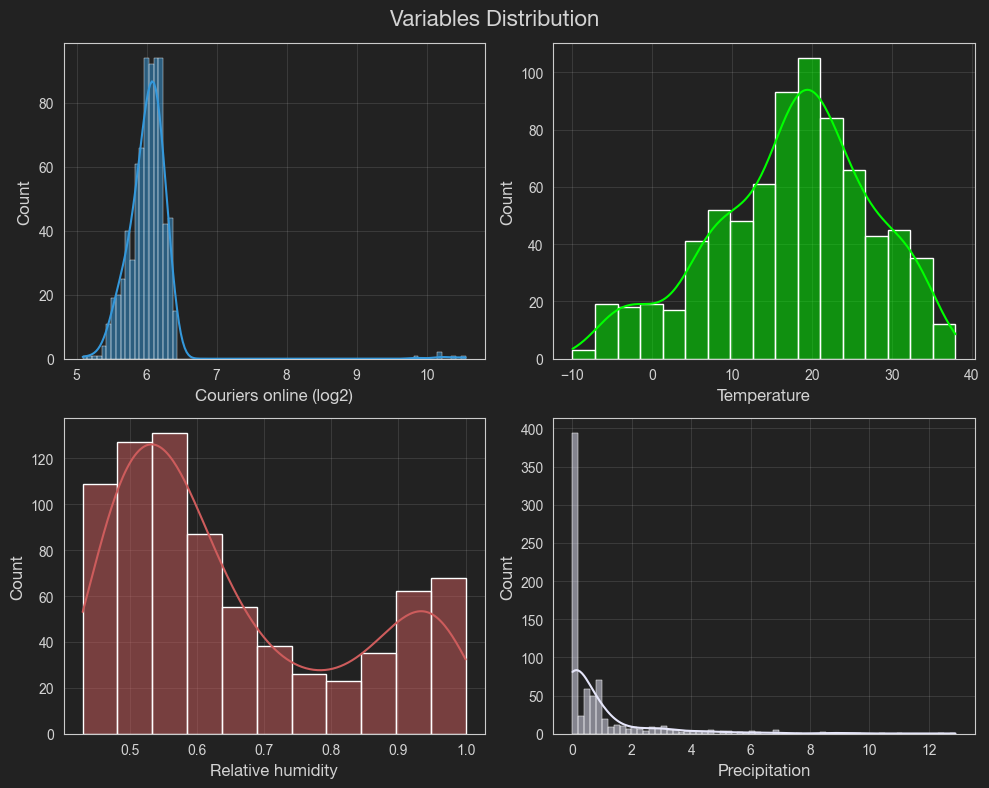

In [76]:
# Univariate Analysis

# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Flatten the axes for easy numeration
axes = axes.flatten()

# Drawing histograms
axes[0].set_xlabel('Couriers online (log2)', color='lightgray', fontproperties=font_12)
sns.histplot(np.log2(df.courier_partners_online), kde=True, ax=axes[0], color=colors[2])

axes[1].set_xlabel('Temperature', color='lightgray', fontproperties=font_12)
sns.histplot(df.temperature, kde=True, ax=axes[1], color=colors[5])

axes[2].set_xlabel('Relative humidity', color='lightgray', fontproperties=font_12)
sns.histplot(df.relative_humidity, kde=True, ax=axes[2], color=colors[8])

axes[3].set_xlabel('Precipitation', color='lightgray', fontproperties=font_12)
sns.histplot(df.precipitation, kde=True, ax=axes[3], color=colors[11])

# Adjust layout
for ax in axes:
    ax.set_facecolor('#222222')
    ax.grid(linewidth=0.5, color='lightgrey', alpha=0.2)
    ax.tick_params(colors='lightgrey')
    ax.set_ylabel('Count', color='lightgray', fontproperties=font_12)

fig.set_facecolor('#222222')
# plt.xticks(fontproperties=font_12)
# plt.yticks(fontproperties=font_12)
plt.suptitle("Variables Distribution", color='lightgray', fontproperties=font_16)
plt.tight_layout()
plt.show()

- Couriers online distribution looks like a normal distribution with outliers.
- Temperature distribution looks like a normal distribution.
- Relative humidity and precipitation appear to have a bimodal distribution. I suspect they are related; that is, there is approximately 0.5 humidity if there is no precipitation, and approximately 1 humidity otherwise.

### Outliers

In [77]:
# Isolate courier online outliers, which more then Q3 + 1.5 IQR to study them separately.
# Calculate the first quartile (Q1)
q1 = df['courier_partners_online'].quantile(0.25)

# Calculate the third quartile (Q3)
q3 = df['courier_partners_online'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
iqr = q3 - q1

# Separate outliers to the distinct DataFrame
df_outliers = df[df.courier_partners_online > q3 + iqr]

# Change outliers to their interpolations to avoid date gaps
df['courier_partners_online'] = df['courier_partners_online'].apply(
    lambda x: x if x <= q3 + iqr else np.nan)
df = df.interpolate(method='ffill')

# Show outliers
df_outliers

,date,courier_partners_online,temperature,relative_humidity,precipitation
1,2021-05-02,927,19.88,0.55,0.00
138,2021-09-16,1367,30.68,0.46,0.00
269,2022-01-25,1176,-2.61,0.92,0.84
326,2022-03-23,1506,22.81,0.55,0.00
635,2023-01-26,1175,-1.88,0.92,0.85


It seems the outliers have no discernible pattern (at least with the limited data available), and I consider them to be barely predictable. I see two possible reasons for them: Some significant events occurred on these days, or the data may be accidentally corrupted (due to system failure or other issues), which may require further investigation.

There's also a possibility of intentional data corruption.

### Visual observation

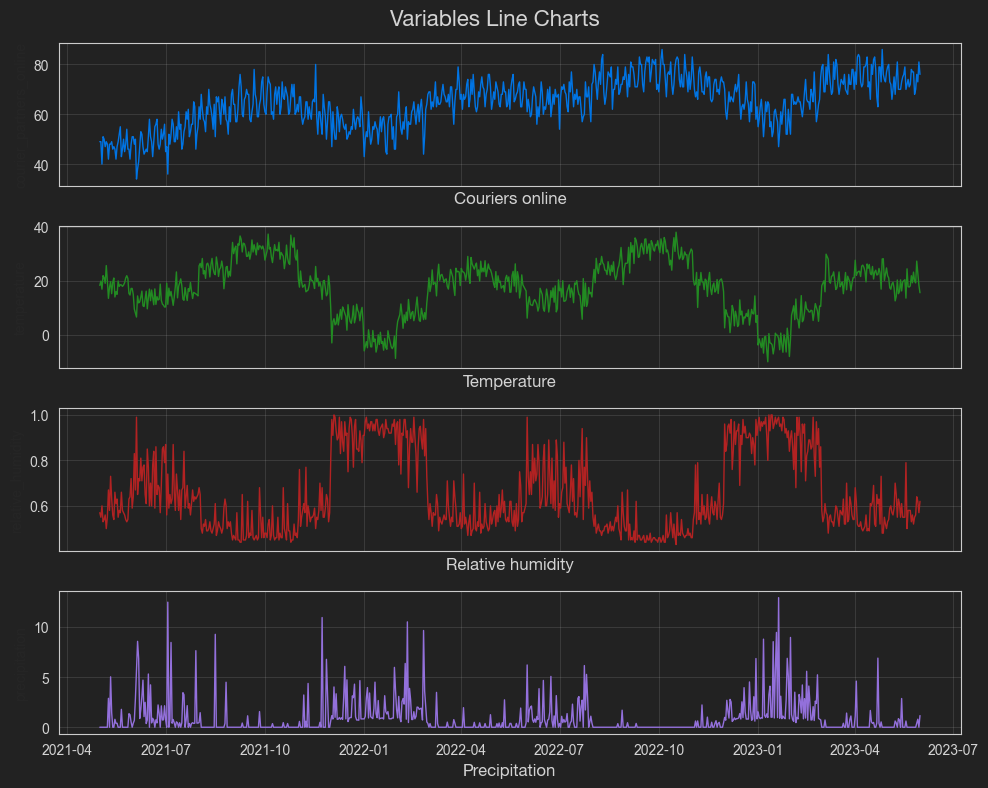

In [81]:
# Set up subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8), sharex=True)

# Flatten the axes for easy numeration
axes = axes.flatten()

# Drawing line charts
axes[0].set_xlabel('Couriers online', color='lightgray', fontproperties=font_12)
sns.lineplot(x='date', y='courier_partners_online', data=df, ax=axes[0], color=colors[1], linewidth=1)

axes[1].set_xlabel('Temperature', color='lightgray', fontproperties=font_12)
sns.lineplot(x='date', y='temperature', data=df, ax=axes[1], color=colors[4], linewidth=1)

axes[2].set_xlabel('Relative humidity', color='lightgray', fontproperties=font_12)
sns.lineplot(x='date', y='relative_humidity', data=df, ax=axes[2], color=colors[7], linewidth=1)

axes[3].set_xlabel('Precipitation', color='lightgray', fontproperties=font_12)
sns.lineplot(x='date', y='precipitation', data=df, ax=axes[3], color=colors[10], linewidth=1)

# Adjust layout
plt.suptitle("Variables Line Charts", fontproperties=font_16, color='lightgrey')
plt.tight_layout()

for ax in axes:
    ax.set_facecolor('#222222')
    ax.grid(linewidth=0.5, color='lightgrey', alpha=0.2)
    ax.tick_params(colors='lightgrey')
    
fig.set_facecolor('#222222')
# fig.set_edgecolor('#222222')
# plt.xticks(fontproperties=font_12)
# plt.yticks(fontproperties=font_12)

plt.show()

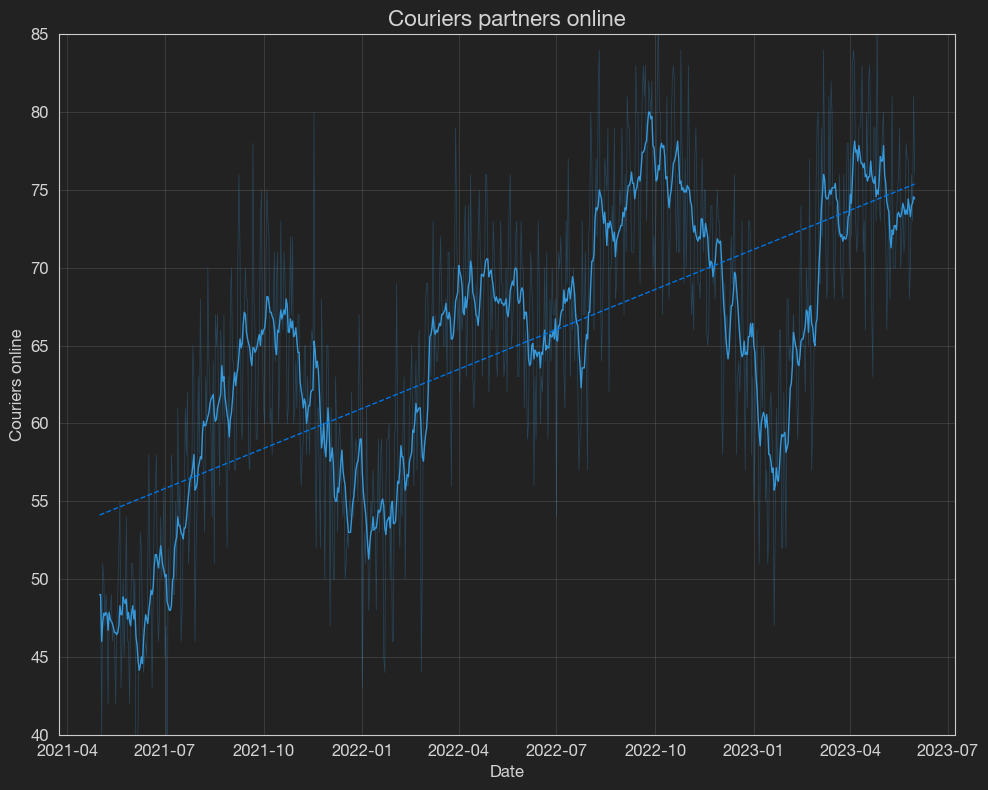

In [86]:
# Closer look at couriers online

# Calculate local averages using a rolling window
week_avg = df['courier_partners_online'].rolling(window=7, min_periods=1).mean()

# Fit a regression line
coefficients = np.polyfit(df.index, df['courier_partners_online'], deg=1)
trendline = np.polyval(coefficients, df.index)

# Set up subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), sharex=True)

# Drawing histograms
sns.lineplot(x='date', y='courier_partners_online', data=df, color=colors[2], alpha=0.3, linewidth=0.5, ax=ax)
sns.lineplot(x='date', y=week_avg, data=df, color=colors[2], linewidth=1, ax=ax)
ax.plot(df['date'], trendline, color=colors[1], linestyle='--', linewidth=1)

# Adjust layout
ax.grid(linewidth=0.5, color='lightgrey', alpha=0.2)
ax.set_xlabel('Date', color='lightgrey', fontproperties=font_12)
ax.set_ylabel('Couriers online', color='lightgrey', fontproperties=font_12)
ax.set_facecolor('#222222')
fig.set_facecolor('#222222')

plt.tick_params(colors='lightgrey')
plt.xticks(fontproperties=font_12)
plt.yticks(fontproperties=font_12)

plt.ylim(40, 85)
plt.title("Couriers partners online", fontproperties=font_16, color='lightgrey')
plt.tight_layout()
plt.show()

In [87]:
print(f"Intercept is {coefficients[1]}, Slope is {coefficients[0]}")

Intercept is 54.11297815762519, Slope is 0.027982653095121438


Observations:

- All the graphs have a period; the major period is 1 year, and the minor period is approximately 1/2 year.
- Temperature and couriers online have a similar shape, while relative humidity has the opposite shape.
- Couriers online exhibit a rising trend.
- Relative humidity and precipitation are positively related in some way.

Further:

- Scatter plots may better expose the dependencies.

### Correlations

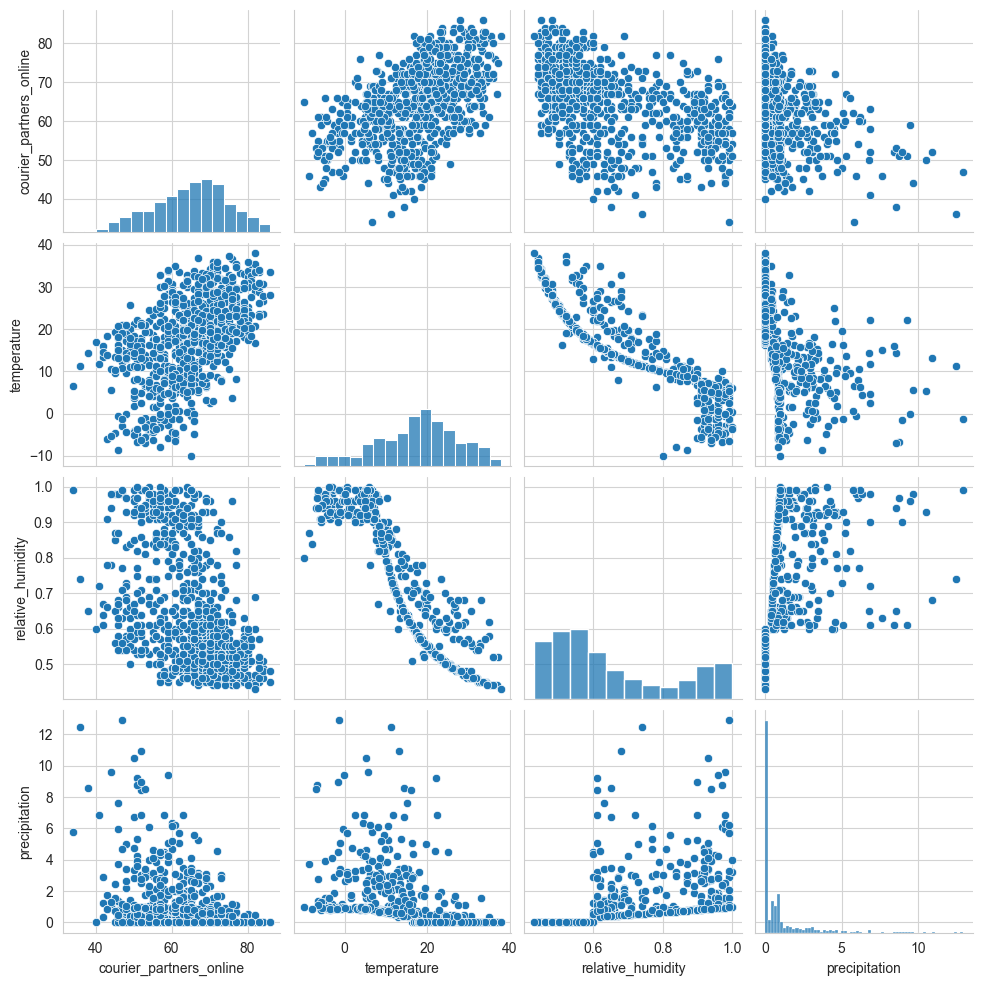

In [92]:
# Scatter plots for each pair
sns.pairplot(df)

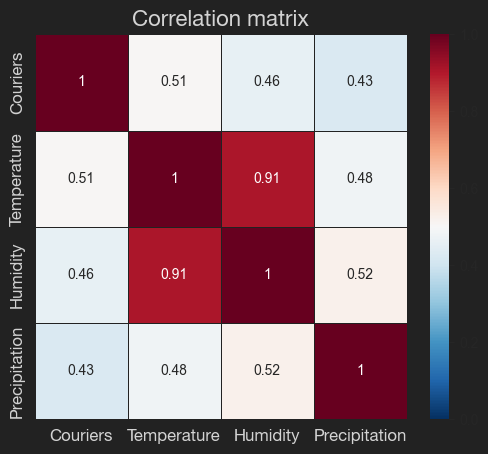

In [95]:
# Correlations for each pair
correlation_matrix = abs(df.corr(numeric_only=True))

# Set up subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5), sharex=True)

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r',
            linewidths=0.5, vmin=0, vmax=1, linecolor='#222222', 
            xticklabels=['Couriers', 'Temperature', 'Humidity', 'Precipitation'],
            yticklabels=['Couriers', 'Temperature', 'Humidity', 'Precipitation'], ax=ax)

# Adjust layout
fig.set_facecolor('#222222')
plt.tick_params(colors='lightgrey')
plt.xticks(fontproperties=font_12)
plt.yticks(fontproperties=font_12)
plt.title("Correlation matrix", fontproperties=font_16, color='lightgrey')
plt.show()

Observations:

- The dependent variable has correlations with all the independent variables.
- Temperature and relative humidity show a very strong correlation of -0.91.
- The graph between relative humidity and temperature exhibits a reverse saturation with a hyperbolic relation.
- The precipitation and temperature graph resembles a ReLU function.
- The precipitation and relative humidity graph also resembles a ReLU, but reversed.

Conclusions:

- Observations regarding weather conditions are interesting, but it's advisable to defer in-depth analysis to meteorologists.
- It might be reasonable to categorize relative humidity into two groups with a discriminant around 0.8.
- The strong correlation between temperature and relative humidity suggests that PCA or some other dimensionality reduction technique may be needed (or use only one feature from these two).
- Possibly, it makes sense to split precipitation into two groups with a discriminant around 0. Let's take a closer look:

### Additional observations

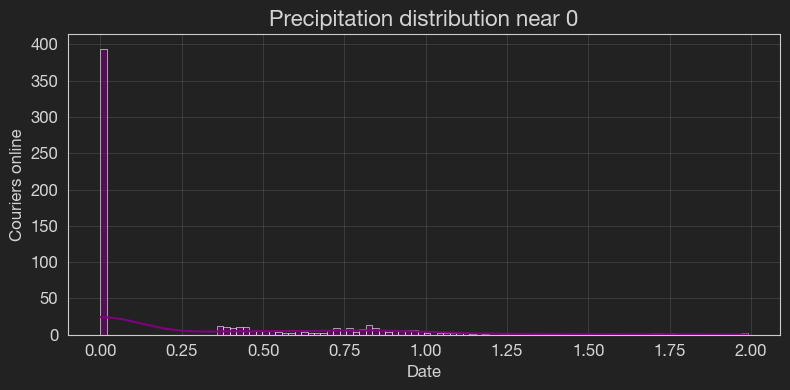

In [103]:
# Closer look at precipitation distribution near 0

# Set up subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4), sharex=True)

# Drawing histograms
sns.histplot(df.precipitation[df.precipitation < 2], kde=True, color=colors[9], bins=100, ax=ax)

# Adjust layout
ax.grid(linewidth=0.5, color='lightgrey', alpha=0.2)
ax.set_xlabel('Date', color='lightgrey', fontproperties=font_12)
ax.set_ylabel('Couriers online', color='lightgrey', fontproperties=font_12)
ax.set_facecolor('#222222')
fig.set_facecolor('#222222')

plt.tick_params(colors='lightgrey')
plt.xticks(fontproperties=font_12)
plt.yticks(fontproperties=font_12)

plt.title("Precipitation distribution near 0", fontproperties=font_16, color='lightgrey')
plt.tight_layout()
plt.show()

- Possibly, it makes sense to split precipitation into two groups with a discriminant around 0. About half of the days showed no precipitations.

## FEATURE ENGINEERING

Date remains unused as of now. The weather is approximately the same from year to year but varies on a daily, weekly, and monthly scale, making predictions challenging.

So, I have two other hypotheses to check:

1. I observed a rising trend, and perhaps the number of days from the start will be useful in a regression model.
2. Considering that people work on business days, there may be some differences depending on the day of the week.

Therefore, I'm going to obtain the day of the week and the number of days from the start.

In [104]:
# creating new features
df['days_from_start'] = (df['date'] - df['date'].min()).dt.days
df['dayofweek'] = df['date'].apply(lambda d: d.day_of_week)
df['day_name'] = df['date'].apply(lambda d: d.day_name())

In [105]:
df.head()

,date,courier_partners_online,temperature,relative_humidity,precipitation,days_from_start,dayofweek,day_name
0,2021-05-01,49.0,18.27,0.57,0.0,0,5,Saturday
1,2021-05-02,49.0,19.88,0.55,0.0,1,6,Sunday
2,2021-05-03,40.0,16.88,0.60,0.0,2,0,Monday
3,2021-05-04,51.0,21.88,0.53,0.0,3,1,Tuesday
4,2021-05-05,50.0,21.11,0.54,0.0,4,2,Wednesday


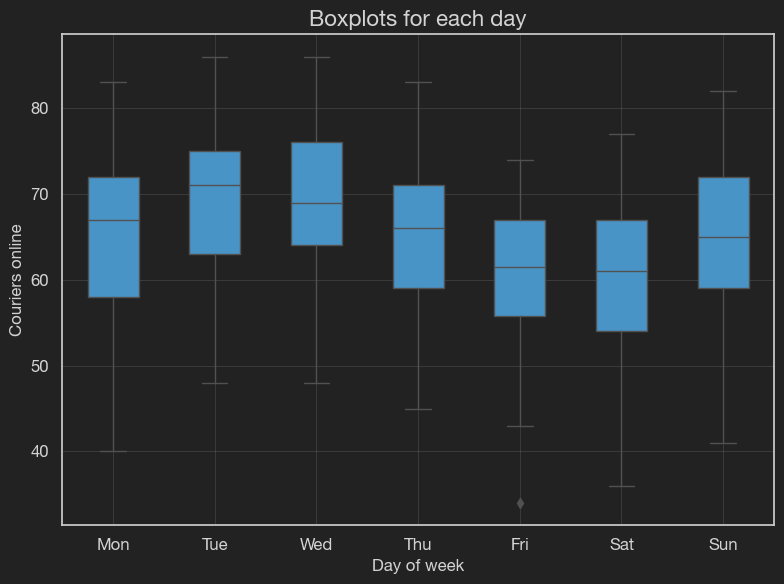

In [108]:
# Boxplots for each day of week

# Set the Seaborn theme and customize background color
sns.set_theme(style="whitegrid", rc={"axes.facecolor": "#222222", "grid.color": "lightgray"})

# Set up subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), sharex=True)

# Drawing histograms
sns.boxplot(x='dayofweek', y='courier_partners_online', data=df, color=colors[2], width=0.5, linewidth=1, ax=ax)
plt.xticks(ticks=range(0,7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Adjust layout
ax.grid(linewidth=0.5, color='lightgrey', alpha=0.2)
ax.set_xlabel('Day of week', color='lightgrey', fontproperties=font_12)
ax.set_ylabel('Couriers online', color='lightgrey', fontproperties=font_12)
ax.set_facecolor('#222222')
fig.set_facecolor('#222222')

plt.tick_params(colors='lightgrey')
plt.xticks(fontproperties=font_12)
plt.yticks(fontproperties=font_12)

plt.title("Boxplots for each day", fontproperties=font_16, color='lightgrey')
plt.tight_layout()
plt.show()

In [109]:
# Describing each day separately, sorted by means
df.groupby('day_name')['courier_partners_online'].describe().sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
day_name,,,,,,,,
Friday,108.0,60.296296,8.363538,34.0,55.75,61.5,67.0,74.0
Saturday,109.0,60.467890,9.131314,36.0,54.00,61.0,67.0,77.0
Sunday,109.0,64.660550,9.364255,41.0,59.00,65.0,72.0,82.0
Thursday,108.0,64.685185,9.005344,45.0,59.00,66.0,71.0,83.0
Monday,109.0,65.192661,9.622964,40.0,58.00,67.0,72.0,83.0
Tuesday,109.0,68.568807,9.647843,48.0,63.00,71.0,75.0,86.0
Wednesday,109.0,69.311927,8.740812,48.0,64.00,69.0,76.0,86.0


I'm going to compare them statistically in the statistics chapter

## TIME SERIES ANALYSIS

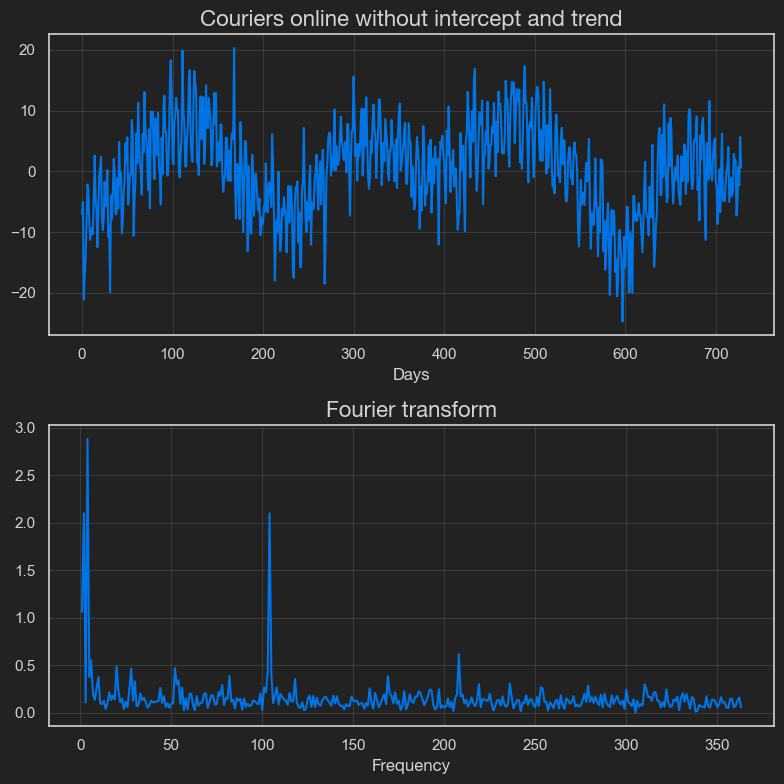

In [120]:
# Get data for the last 2 years to have a better seasoning
two_years_ago = df['date'].max() - pd.DateOffset(weeks=104)
days_from = len(df[df['date'] >= two_years_ago])

# Subtract the trendline to get better result
# Fit a regression line
coefficients = np.polyfit(df.index, df['courier_partners_online'], deg=1)
trendline = np.polyval(coefficients, df.index)
y = df[df['date'] >= two_years_ago]['courier_partners_online'] - trendline[-1 * days_from:]

# Apply Fourier Transform
n = len(y)  # Length of the signal
k = np.arange(n)
T = 1
frq = k/T  # Two sides frequency range
frq = frq[:n//2]  # One side frequency range

Y = np.fft.fft(y)/n  # Fourier Transform and normalization
Y = Y[:n//2]

# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), sharex=False)

# Flatten the axes for easy numeration
axes = axes.flatten()

# Plot the time series and its frequency domain representation
axes[0].set_title("Couriers online without intercept and trend", fontproperties=font_16, color='lightgrey')
axes[0].set_xlabel('Days', color='lightgrey', fontproperties=font_12)
axes[0].plot(k, y, color=colors[1])

axes[1].set_title("Fourier transform", fontproperties=font_16, color='lightgrey')
axes[1].set_xlabel('Frequency', color='lightgrey', fontproperties=font_12)
axes[1].plot(frq[1:], abs(Y[1:]), color=colors[1])

# Adjust layout
for ax in axes:
    ax.grid(linewidth=0.5, color='lightgrey', alpha=0.2)
    ax.set_facecolor('#222222')
    ax.tick_params(colors='lightgrey')

fig.set_facecolor('#222222')
plt.tight_layout()
plt.show()

In [121]:
# print all the possibly peak frequences
for i in range(1, len(Y)):
    if abs(Y[i]) > 1:
        print(f"Frequency is {i}, Period in days is {round(2*len(Y)/i)}, Amplitude is {abs(Y[i])}")

Frequency is 1, Period in days is 728, Amplitude is 1.0630720607345028
Frequency is 2, Period in days is 364, Amplitude is 2.10395902949346
Frequency is 4, Period in days is 182, Amplitude is 2.8833504319187324
Frequency is 104, Period in days is 7, Amplitude is 2.1011264391276514


As we can see, there are most affecting frequencies, with periods of 1 year, 1/2 year and 1 week.

## STATISTICS

### Difference between week days

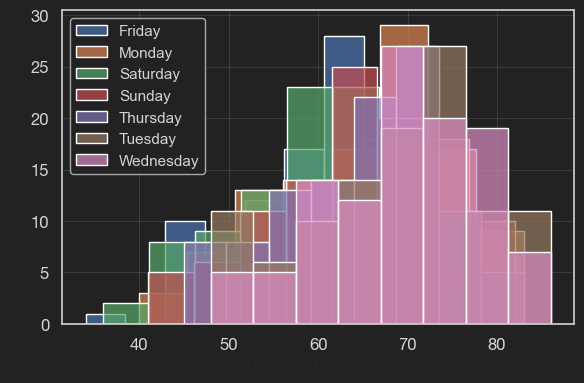

In [143]:
# Group data by weekdays
group_by_weekdays = df.groupby('day_name')['courier_partners_online']

# Set up subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharex=False)

for group, group_data in group_by_weekdays:
    sns.histplot(group_data, bins='auto', alpha=0.7, label=group, ax=ax)
    
# Adjust layout

ax.grid(linewidth=0.5, color='lightgrey', alpha=0.2)
ax.set_facecolor('#222222')
# ax.tick_params(colors='lightgrey')

fig.set_facecolor('#222222')
plt.tick_params(colors='lightgrey')
plt.xticks(fontproperties=font_12)
plt.yticks(fontproperties=font_12)
plt.legend(labelcolor='lightgray')
plt.tight_layout()
plt.show()

- They looks like right skewed normal distributions

In [142]:
# Perform Shapiro-Wilk test for each group
shapiro_results = group_by_weekdays.apply(lambda x: stats.shapiro(x)[1])
shapiro_results

day_name
Friday       0.004303
Monday       0.076476
Saturday     0.096946
Sunday       0.038083
Thursday     0.007740
Tuesday      0.005323
Wednesday    0.055067
Name: courier_partners_online, dtype: float64

- This test didn't reaffirm normality for all of the days
- I'll perform both parametric and non-parametric tests

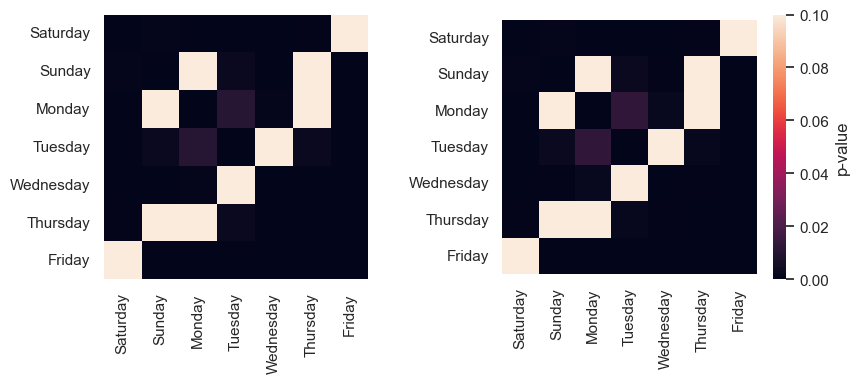

In [194]:
# groups = combinations(group_by_weekdays.groups.keys(), 2)
# Create a matrix to store t-test results
groups = df['day_name'].unique()
t_test_matrix = pd.DataFrame(index=groups, columns=groups)
mannwhitneyu_matrix = pd.DataFrame(index=groups, columns=groups)

# Perform independent t-tests for all pairs of groups
for group1, group2 in combinations(groups, 2):
    values1 = df[df['day_name'] == group1]['courier_partners_online']
    values2 = df[df['day_name'] == group2]['courier_partners_online']
    
    # Independent t-test
    t_statistic, p_value = stats.ttest_ind(values1, values2)

    t_test_matrix.loc[group1, group2] = p_value
    t_test_matrix.loc[group2, group1] = p_value
    
    # Mann-Whitney U-test
    t_statistic, p_value = stats.mannwhitneyu(values1, values2)
    
    mannwhitneyu_matrix.loc[group1, group2] = p_value
    mannwhitneyu_matrix.loc[group2, group1] = p_value

# Display the matrix of p-values

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharex=False)

# Flatten the axes for easy numeration
axes = axes.flatten()

t_test_matrix = t_test_matrix.fillna(0)
sns.heatmap(t_test_matrix, vmax=0.1, ax=axes[0], cbar=False, square=True)

mannwhitneyu_matrix = mannwhitneyu_matrix.fillna(0)
sns.heatmap(mannwhitneyu_matrix, vmax=0.1, ax=axes[1], square=True, cbar_kws={'label':'p-value'})

# Adjust layout
for ax in axes:
    ax.set_facecolor('#222222')
#     ax.tick_params(colors='lightgrey')

fig.set_facecolor('#ffffff')
plt.tight_layout()
plt.show()

Conclusions:

**Three groups of weekdays were confirmed statistically:**

* Sun, Mon, Thu
* Tue, Wed
* Fri, Sat

### Correlation with day index

In [195]:
# Correlation between couriers online and days from beginning
cor = df['courier_partners_online'].corr(df['days_from_start'])

print(f"Correlation between couriers online and days from start is: {round(abs(cor), 3)}")

Correlation between couriers online and days from start is: 0.637


- There is a strong correlation between the variable and days from beginning

### Stationarity of the time series

In [196]:
# Check for stationarity

# Original time series
result = adfuller(df['courier_partners_online'])
print('For original time series:')
print('ADF statistics:', result[0])
print('p-value:', result[1])
print('Critical values:')
for key, value in result[4].items():
    print(f'  {key}: {value}')

# Time series minus moving average
# Calculate local averages using a rolling window
week_avg = df['courier_partners_online'].rolling(window=7, min_periods=1).mean()

result = adfuller(df['courier_partners_online'] - week_avg)
print('\nFor time series minus moving average:')
print('ADF statistics:', result[0])
print('p-value:', result[1])
print('Critical values:')
for key, value in result[4].items():
    print(f'  {key}: {value}')

For original time series:
ADF statistics: -1.9751824644016873
p-value: 0.29755959876293664
Critical values:
  1%: -3.4392177416762086
  5%: -2.8654536415414684
  10%: -2.5688540485756026

For time series minus moving average:
ADF statistics: -5.718988629846842
p-value: 7.012512414444137e-07
Critical values:
  1%: -3.4392177416762086
  5%: -2.8654536415414684
  10%: -2.5688540485756026


Conclusions:

- The original time series is not stationary due to seasonality and trend.
- It becomes stationary when the moving average is subtracted.


## OBSERVATIONS AND CONCLUSIONS

**Observations**

1. The data is a time series with:
- A rising trend (~0.03 per day).
- A seasonal factor with a period of 1 year and a subperiod of 1/2 year.
- A weekly pattern, which could possibly be described as a sinusoid and surely can be categorized into three different groups.

2. There are moderately strong correlations between all the given variables, with a particularly strong correlation between relative humidity and temperature.

**Conclusions for modeling**

I see two main approaches to creating the model: one with known (predicted by meteorologists) weather conditions and the other without.

1. With Known Weather Conditions:
- It could be a simple linear regression model, incorporating variables such as the day from the beginning, the ordinal category of days of the week, temperature, and precipitation.
2. With Unknown Weather Conditions:
- In this kind of model, relying on weather condition data is impossible, only on time series. Hence, it makes sense to explore any model suitable for seasoned time series prediction.

Personally I would consider the following model for unknown weather condition:

$$y=I + Sx + \sum_{i=1}^{3} A_i sin(2\pi F_i x + P_i))$$

Here, $y$ is couriers online, $x$ is the day index, $I$ is Intercept, $S$ is Slope, three sines describe 1 year, 1/2 year and 1 week oscilations with $A_i$ - Amplitudes, $F_i$ - Frequencies and $P_i$ - Phase shifts.

Then, I would train the model to find the most suitable coefficients. (*)

**Conclusions about processing**

To build further a few different models, I would consider the following processing steps:

1. Parse dates.
2. Interpolate missing weather conditions data.
3. Find anomalies in couriers online, save them to the distinct file and then change values to interpolated (to save the date order).
4. Extract Day names out of date column.
5. Create Day type ordinal variable out of day names (0, 1, 2 for three groups ordered by mean).
6. Normalization of feature numeric variables

---
---
## (*) Approximate own model

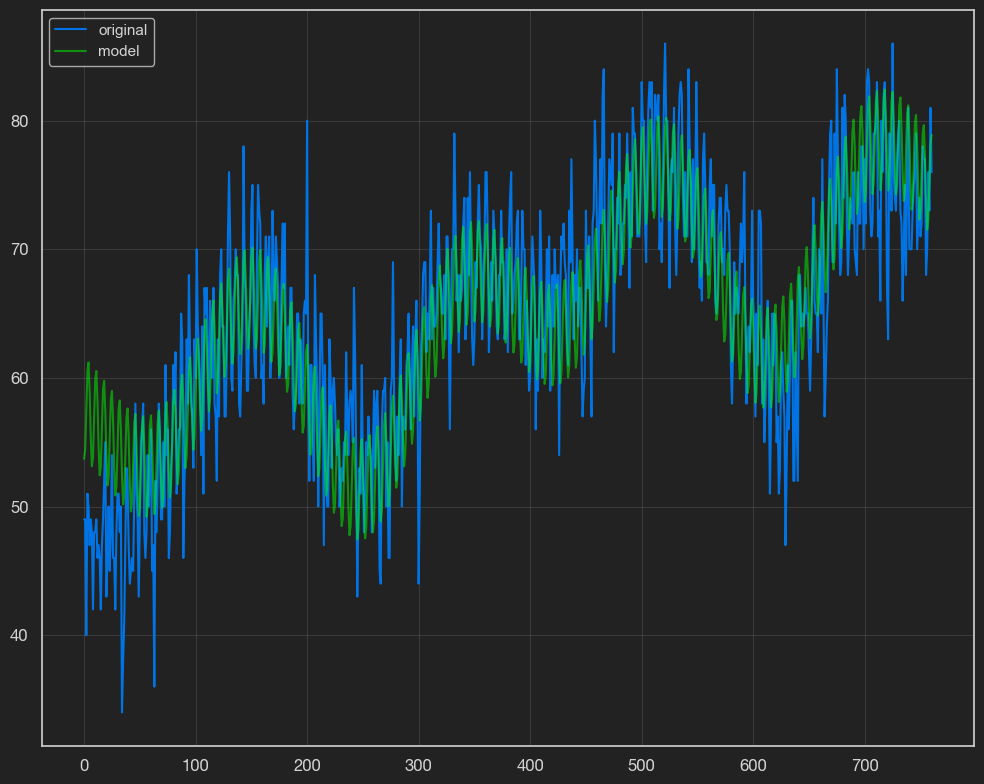

In [204]:
# Very approximate hand-built model that I meant

# Define X
x = df['days_from_start']

# Define one line and 3 sinusoides with hardcoded coefficients
week_sine = pd.Series(np.sin(2 * np.pi / 7 * (x-2)), index=x)
half_year_sine = pd.Series(np.sin(2 * np.pi / 182.5 * (x-110)), index=x)
year_sine = pd.Series(np.sin(2 * np.pi / 365 * (x)), index=x)
trend_line = pd.Series(54 + 0.028 * x, index=x)

# Set up subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), sharex=False)

# Plot
ax.plot(df['courier_partners_online'], alpha=1, color=colors[1], label="original")
ax.plot((trend_line + 4 * year_sine + 6 * half_year_sine + 4 * week_sine), alpha=0.5, color=colors[5], label="model")
    
# Adjust layout

ax.grid(linewidth=0.5, color='lightgrey', alpha=0.2)
ax.set_facecolor('#222222')
# ax.tick_params(colors='lightgrey')

fig.set_facecolor('#222222')
plt.tick_params(colors='lightgrey')
plt.xticks(fontproperties=font_12)
plt.yticks(fontproperties=font_12)
plt.legend(labelcolor='lightgray')
plt.tight_layout()
plt.show()